In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as fn
from torch.autograd import Variable
import matplotlib
import torch.nn.functional as F 
import numpy as np
import pickle

import matplotlib.pyplot as plt

from scipy import optimize
from scipy.optimize import minimize

In [2]:
import torch
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())


__Python VERSION: 3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 18:21:58) 
[GCC 7.2.0]
__pyTorch VERSION: 0.4.0
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2015 NVIDIA Corporation
Built on Tue_Aug_11_14:27:32_CDT_2015
Cuda compilation tools, release 7.5, V7.5.17
__CUDNN VERSION: 7102
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


In [3]:
train_xyz = []

with open('training/8v/data.pickle', 'rb') as f:
    data = pickle.load(f)

for i in range(len(data)):
    obj = np.asarray(data[i])
    #print("obj: ", obj)
    nv = 8
    dim = 36
    #print(obj.shape)
    train_xyz.append((obj))
    #print(train_xyz)
train_xyz = torch.Tensor(train_xyz)
train_xyz.shape  

torch.Size([10000, 3, 36])

In [4]:
test_xyz = []

with open('test/8v/data.pickle', 'rb') as f:
    data = pickle.load(f)

for i in range(len(data)):
    obj = np.asarray(data[i])
    #print("obj: ", obj)
    nv = 8
    dim = 36
    #print(obj.shape)
    test_xyz.append((obj))
    #print(train_xyz)
test_xyz = torch.Tensor(test_xyz)
test_xyz.shape  

torch.Size([1000, 3, 36])

In [5]:
train_xy = []

with open('training/8v/data.pickle', 'rb') as f:
    data = pickle.load(f)
    
for i in range(len(data)):
    obj = np.asarray(data[i])
    obj[2,0:8]=np.random.rand(8)
    train_xy.append(obj)
    #print(train_xyz)
train_xy = torch.Tensor(train_xy)
train_xy.shape        

torch.Size([10000, 3, 36])

In [6]:
test_xy = []

with open('test/8v/data.pickle', 'rb') as f:
    data = pickle.load(f)
    
for i in range(len(data)):
    obj = np.asarray(data[i])
    #print(obj.shape)
    #print("prev:", obj)
    obj[2,0:8]=np.random.rand(8)
    #print("rand:",obj)
    test_xy.append(obj)
    #print(train_xyz)
test_xy = torch.Tensor(test_xy)
test_xy.shape        

torch.Size([1000, 3, 36])

In [17]:
# new version
import torch.nn.functional as F 
import statistics
from functools import reduce

vertices = 8

def num_edges(n):
    return int(n*(n-1)/2)

grads = {}
for i in ['sym','msda']:
    grads[i] = 0

def save_grad(name):
    def hook(grad):
        grads[name] = grad
    return hook


class DepthEstNet(nn.Module):    
    def __init__(self, vertices, nonlinearity = fn.tanh, additional_hidden_wide=0):
        super(DepthEstNet, self).__init__()
        self.vertices = vertices
        self.z_star = torch.Tensor([vertices])
        input_dim = vertices * 3
        self.edges = int(num_edges(vertices))
        edge_dim = self.edges * 3
        edges = self.edges
        
        self.fc0 = nn.Linear(vertices, vertices)
        
        self.msda_conv_edge_vec = nn.ModuleList()
        self.conv_edge_num = vertices-1
        
        for i in range(1,vertices):
            m = nn.Conv1d(3, 3, 2, stride=1, dilation=i)
            m.weight = torch.nn.Parameter(torch.from_numpy(np.array(
            [[[1, -1],
             [0, 0],
             [0, 0]],
    
            [[0, 0],
             [1,-1],
             [0,0]],

            [[0,  0],
             [0, 0],
             [1, -1]]], dtype=np.float32)))
            m.bias = torch.nn.Parameter(torch.from_numpy(np.array([0,0,0], dtype=np.float32)))
            m.requires_grad = False
            self.msda_conv_edge_vec.append(m)
        

                
        self.sym_conv_edge_vec = nn.ModuleList()
        self.sym_edge_num = vertices-1
        
        for i in range(1,vertices):
            m = nn.Conv1d(3, 3, 2, stride=1, dilation=i)
            m.weight = torch.nn.Parameter(torch.from_numpy(np.array(
            [[[1, -1],
             [0, 0],
             [0, 0]],
    
            [[0, 0],
             [1,-1],
             [0,0]],

            [[0,  0],
             [0, 0],
             [1, -1]]], dtype=np.float32)))
            m.bias = torch.nn.Parameter(torch.from_numpy(np.array([0,0,0], dtype=np.float32)))
            m.requires_grad = False
            self.sym_conv_edge_vec.append(m)
            
        
        self.msda_deconv_edge_vec = nn.ModuleList()
        self.deconv_edge_num = vertices-1
        for i in range(1,vertices):
            m = nn.Conv1d(3, 3, 2, stride=1, dilation=vertices-i)
            m.requires_grad = True
            self.msda_deconv_edge_vec.append(m)        
        
        
        self.reverse_learn_params = nn.ModuleList()
        fc1 = nn.Linear(edges, edges*10)
        self.reverse_learn_params.append(fc1)
        fc2 = nn.Linear(edges*10, edges*20)
        self.reverse_learn_params.append(fc2)
        fc3 = nn.Linear(edges*20, vertices*20)
        self.reverse_learn_params.append(fc3)        
        fc4 = nn.Linear(vertices*20, vertices*10)
        self.reverse_learn_params.append(fc4)
        fc5 = nn.Linear(vertices*10, vertices)
        self.reverse_learn_params.append(fc5)
        
        self.layernorm = nn.LayerNorm(edges)
        self.nonlinearity = nonlinearity
        self.cos = nn.CosineSimilarity(dim=0, eps=1e-6)

    
    def train_reverse_map(self, x, output):
        x_vec =  output[:,0,:]
        temp = (self.reverse_learn_params[0](x_vec))
        temp = (self.reverse_learn_params[1](temp))
        temp = (self.reverse_learn_params[2](temp))
        temp = (self.reverse_learn_params[3](temp))
        vertexs_recovered = (self.reverse_learn_params[4](temp))
        optimizer = torch.optim.SGD(self.reverse_learn_params.parameters(), lr = 1e-1 , momentum=0.8)
        criterion = nn.MSELoss()
        optimizer.zero_grad()
        loss = criterion(vertexs_recovered, x[:,0,:])
        loss.backward(retain_graph=True)
        optimizer.step()
        
    def recover_z_star(self, output):
        vec = output[:,2,:] 
        temp = (self.reverse_learn_params[0](vec))
        temp = (self.reverse_learn_params[1](temp))
        temp = (self.reverse_learn_params[2](temp))
        temp = (self.reverse_learn_params[3](temp))
        vertexs_recovered = (self.reverse_learn_params[4](temp))
        self.z_star = vertexs_recovered
        return self.z_star
        
    def msda(self, x, conn):
        for i in range(self.conv_edge_num):
            y = self.msda_conv_edge_vec[i](x)
            if (i==0):
                output = y
            else:
                output = torch.cat((output,y), dim=2)
        self.train_reverse_map(x,output)
        y = output
        output = output*conn
        z_star = self.recover_z_star(output)
        return z_star,output     
    
    def sym(self, x, conn):
        for i in range(self.conv_edge_num):
            y = self.sym_conv_edge_vec[i](x)
            if (i==0):
                output = y
            else:
                output = torch.cat((output,y), dim=2)
        self.train_reverse_map(x,output)
        y = output
        output = output*conn
        z_star = self.recover_z_star(output)
        return z_star,output
    
    
    def f_msda(self,G,z_star):
        n,d,e = G.size()
        normalizedG= F.normalize(G,p=2,dim=1)
        SDA_mat = [torch.mm(mat.transpose(1,0),mat) for mat in normalizedG[:]]
        output_mat = Variable(torch.std(torch.stack(SDA_mat)), requires_grad=True)
        #output_mat = torch.stack(SDA_mat)
        output_mat.register_hook(save_grad('msda'))
        #print("GRAD msda ", grads['msda'])
        return output_mat

    
    def f_sym(self,x,y,z):
        xbar = x-torch.mean(x)
        ybar = y-torch.mean(y)
        zbar = z-torch.mean(z)
        C = torch.stack([xbar ,ybar, zbar])
        C = C.transpose(2,0)
        D = [torch.norm(c,p=2) for c in C]
        D = torch.Tensor(D)
        M = statistics.median(D)
        SD = torch.std(D)
        circularity = Variable(SD/M, requires_grad=True)
        circularity.register_hook(save_grad('sym'))
        #print("GRAD sym ", grads['sym'])
        return circularity

    
    def forward(self, x):
        n,d,t = x.size()
        x,conn = torch.Tensor.split(x,[self.vertices,t-self.vertices],dim=2)
        z_star_msda, G = self.msda(x,conn) 
        z_star_sym, output = self.sym(x,conn)
        val_msda = self.f_msda(G,z_star_sym)
        val_sym = self.f_sym(x[:,0,:],x[:,1,:],z_star_sym)
        return [val_msda,val_sym,z_star_msda,z_star_sym,G]
    
    
    def lin_f_t_z_bar(self,t,z,z_bar,g_msda,g_sym,x,y,G):
        v1 = model.f_sym(x,y,z_bar).to(device) - t + (g_sym)*torch.transpose(z-z_bar,1,0)
        v2 = model.f_msda(G,z_bar).to(device) + (g_msda)*torch.transpose(z-z_bar,1,0)
        return max(torch.norm(v1, p=2, dim=0).to(device),torch.norm(v2, p=2, dim=0).to(device))

    def f_gamma(self,t,z,z_bar,g_msda,g_sym,x,y,G,gamma):
        return self.lin_f_t_z_bar(t,z,z_bar,g_msda,g_sym,x,y,G) + torch.mm((z-z_bar),torch.transpose(z-z_bar,1,0))*gamma/2

    def f_star(self,z,*args):
        res = self.f_gamma(*args)
        return res

    def zf(self,t,z_bar,gamma):
        #res = minimize(f_gamma,z)
        return self.z_star
        
    def find_root(self,z,t):
        t = optimize.newton(f_star,t,maxiter=100,tol=0.1)
        return t

    def get_next_z(self,z0,mu,L):
        maxk=100
        beta = (np.sqrt(L)-np.sqrt(mu))/(np.sqrt(L)+np.sqrt(mu))
        y=z0
        z=z0
        for k in range(maxk):
            z_next = self.zf(t,y,L)
            #y = z_next + beta*(z_next-z)
            z = z_next
        return z

In [18]:
#Test cuboid object
data = [[[0.60555981397628784, 1.019606590270996, 0.9311475157737732], 
         [0.7988362312316895, 0.14085637032985687, 1.1584558486938477], 
         [0.83646029531955719, 0.9592991471290588, 1.0384680032730103], 
         [1.040856385231018, 0.20116375386714935, 0.8111595511436462]]]

obj = np.asarray(data,dtype=np.float32)
obj.shape
nv = obj.shape[1]
obj = obj.T.reshape(1,3,nv)
obj = torch.tensor(obj)

print(type(obj))
print(obj.shape)

conn = torch.from_numpy(np.asarray([[[1,1,1,0,0,1],[1,1,1,0,0,1],[1,1,1,0,0,1]]],dtype=np.float32))

print(type(conn))
print(conn.shape)

input =  torch.cat((obj,conn), dim=2)

print(input)

<class 'torch.Tensor'>
torch.Size([1, 3, 4])
<class 'torch.Tensor'>
torch.Size([1, 3, 6])
tensor([[[ 0.6056,  0.7988,  0.8365,  1.0409,  1.0000,  1.0000,  1.0000,
           0.0000,  0.0000,  1.0000],
         [ 1.0196,  0.1409,  0.9593,  0.2012,  1.0000,  1.0000,  1.0000,
           0.0000,  0.0000,  1.0000],
         [ 0.9311,  1.1585,  1.0385,  0.8112,  1.0000,  1.0000,  1.0000,
           0.0000,  0.0000,  1.0000]]])


In [19]:
model = DepthEstNet(nv, nonlinearity=fn.sigmoid, additional_hidden_wide=1)
criterion = nn.L1Loss()

#print(model)
#print(list(model.parameters())[:])
model.forward(torch.Tensor(input))

[tensor(0.6137),
 tensor(0.1034),
 tensor([[ 0.1863,  0.1714,  0.2320,  0.2433]]),
 tensor([[ 0.2329,  0.2525,  0.3040,  0.3387]]),
 tensor([[[-0.1933, -0.0376, -0.2044, -0.0000, -0.0000, -0.4353],
          [ 0.8788, -0.8184,  0.7581,  0.0000, -0.0000,  0.8184],
          [-0.2273,  0.1200,  0.2273, -0.0000,  0.0000,  0.1200]]])]

In [20]:
model = DepthEstNet(vertices, nonlinearity=fn.relu, additional_hidden_wide=1)
criterion = nn.L1Loss()
print(model)

DepthEstNet(
  (fc0): Linear(in_features=8, out_features=8, bias=True)
  (msda_conv_edge_vec): ModuleList(
    (0): Conv1d(3, 3, kernel_size=(2,), stride=(1,))
    (1): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(2,))
    (2): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(3,))
    (3): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(4,))
    (4): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(5,))
    (5): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(6,))
    (6): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(7,))
  )
  (sym_conv_edge_vec): ModuleList(
    (0): Conv1d(3, 3, kernel_size=(2,), stride=(1,))
    (1): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(2,))
    (2): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(3,))
    (3): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(4,))
    (4): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(5,))
    (5): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(6,))


In [21]:
#train_xyz[1000,:,:]

In [22]:
#print(list(model.parameters())[:])

Training #1

In [54]:
import torch.utils.data
dataset = torch.utils.data.TensorDataset(train_xy[1:1000,:,:], train_xyz[1:1000,:,:])
loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)
model.to(device)

lr, epochs, batch_size = 1e-1 , 50 , 10
optimizer = torch.optim.SGD(model.parameters(), lr = lr )
train_accum=[]
i = 0
t = Variable(torch.randn(1,1), requires_grad = True).to(device)
print(t)
maxk=10
gamma=2
mu=1
L=2
kappa = np.random.random()*0.5
epsilon = np.random.random()*0.1
epochaccum = []

cuda:0
tensor([[ 1.3808]], device='cuda:0')


/home/mishra/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


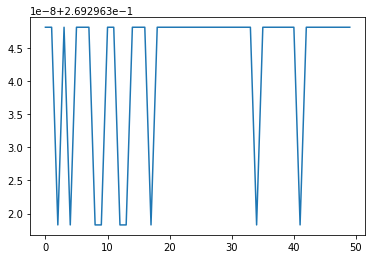

In [55]:
for k in range(epochs):
    localaccum = []
    for xy, xyz in iter(loader):
        i =  i+1
        local_xy = Variable(xy)
        local_xyz = Variable(xyz)
        local_xy = local_xy.to(device)
        outputs = model.forward(local_xy)
        
        output_sda = outputs[0]
        output_sda = output_sda.to(device)

        loss_sda = criterion(output_sda, torch.Tensor.new_zeros(output_sda, output_sda.size()))

        #print(local_xy, local_xyz)
        #if (i%500 == 0): print("network loss -> ", loss)
        
        output_sym = outputs[1]
        output_sym = output_sym.to(device)
        
        model.zero_grad() 
        loss_sda.backward()
        
        optimizer.step()
        localaccum.append(loss_sda.data[0])
        
        #print("GRAD msda ", grads['msda'])
        #print("GRAD msda ", grads['sym'])
        
        z_msda = outputs[2].to(device)
        z_sym = outputs[3].to(device)
        G = outputs[4]
        n,d,l = local_xy.size()
        
        xy,conn = torch.Tensor.split(local_xy,[vertices,l-vertices],dim=2)
        
        g_msda = grads['msda'].to(device)
        g_sym = grads['sym'].to(device)

        args = (t,z_msda,z_sym,g_msda,g_sym,xy[:,0,:],xy[:,1,:],G,gamma)
        fun_min = model.f_gamma(*args)
 
        loss_f_star = criterion(fun_min, torch.Tensor.new_zeros(fun_min, fun_min.size()))
        optimizer.step()
        
        z_k = model.get_next_z(z_msda,mu=2,L=1)
        #print("z_k -> ", z_k)
        for j in range(maxk):
            args1 = (t,z_msda,z_sym,g_msda,g_sym,xy[:,0,:],xy[:,1,:],G,mu)
            args2 = (t,z_msda,z_sym,g_msda,g_sym,xy[:,0,:],xy[:,1,:],G,L)
            if (model.f_star(z_k,*args1) >= (1-kappa)*model.f_star(z_k,*args2)):
                #print(model.f_star(z_k,*args1))
                #print((1-kappa)*model.f_star(z_k,*args2))
                z_kj=z_k
                #print("z_kj=z_k")
                break
            z_kj=model.f_star(zk,L,*args)
            if(f_star(zkj,L,*args) < epsilon):
                #print("z_kj < e")
                break           
            t = find_root(zkj,t)
        #print("z_kj ->", z_kj) 
        sym_val = model.f_sym(xy[:,0,:],xy[:,1,:],z_kj).to(device)
        
        #print(output_sym, sym_val)
        
        loss_sym = criterion(output_sym, sym_val.data)
        loss_sym.backward()
    
    train_accum.append(np.mean(localaccum))
    epochaccum.append(localaccum)
    
plt.plot(train_accum);


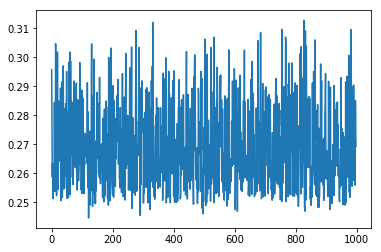

In [58]:
plt.plot(epochaccum[9]);

In [ ]:
plt.plot(train_accum[0:5]);

In [126]:
train_accum

[0.07268874,
 0.0682967,
 0.0679433,
 0.0678957,
 0.06787384,
 0.0678636,
 0.06784907,
 0.06784784,
 0.06784002,
 0.06783069]

TEST BY RENDERING

In [50]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt


    
def test_reconstruct(N):
    print(N)
    print("******************************")
    fig = plt.figure()
    ax = Axes3D(fig)

    test_obj=test_xyz[N,:,:]
    d,t = test_obj.size()
    obj,conn = torch.Tensor.split(test_obj,[8,t-8],dim=1)
    #print(obj)
    #print(conn)
    fullobj = np.concatenate((obj,conn), axis=1)
    computed_z = model.forward(torch.Tensor([fullobj]).to(device), extract_z=True)
    orig_z = obj[2]


    print("_________ORIG________")

    x=obj[0]
    y=obj[1]
    z=obj[2]


    x=[(i-min(x))/(max(x)-min(x)) for i in x]
    y=[(i-min(y))/(max(y)-min(y)) for i in y]
    z=[(i-min(z))/(max(z)-min(z)) for i in z]

    verts = [list(zip(x, y,z))]
    #ax.add_collection3d(Poly3DCollection(verts))
    ax.scatter(x, y, z, c='r', marker='o')
    
    
    xbar = sum(x)/len(x)
    ybar = sum(y)/len(y)
    zbar = sum(z)/len(z)

    ax.scatter(xbar, ybar, zbar, c='b', marker='x')
    
    C = np.array((xbar ,ybar, zbar))
    P = [np.array((x[i] ,y[i], z[i])) for i in range(len(x))]
    #print(C,P)
    D = [np.linalg.norm(a-C) for a in P]
    print(D)
    M = statistics.median(D)
    print(M)
    #SD = statistics.stdev(D)
    SD = np.std(D)
    print(SD)
    circularity = SD/M
    print("circularity: ",circularity)

    plt.show()    



    print("_________RECON________")

    fig = plt.figure()
    ax = Axes3D(fig)
    x=obj[0]
    y=obj[1]
    z=computed_z.to('cpu').detach().numpy()[0]
    #print("Test  obj's   z: ", obj[2])
    #print("Model computed z:", z)

    x=[(i-min(x))/(max(x)-min(x)) for i in x]
    y=[(i-min(y))/(max(y)-min(y)) for i in y]
    z=[(i-min(z))/(max(z)-min(z)) for i in z]

    verts = [list(zip(x, y,z))]
    #ax.add_collection3d(Poly3DCollection(verts))
    ax.scatter(x, y, z, c='r', marker='o')
    
    xbar = sum(x)/len(x)
    ybar = sum(y)/len(y)
    zbar = sum(z)/len(z)

    ax.scatter(xbar, ybar, zbar, c='b', marker='x')
    
    C = np.array((xbar ,ybar, zbar))
    P = [np.array((x[i] ,y[i], z[i])) for i in range(len(x))]
    #print(C,P)
    D = [np.linalg.norm(a-C) for a in P]
    print(D)
    M = statistics.median(D)
    print(M)
    #SD = statistics.stdev(D)
    SD = np.std(D)
    print(SD)
    circularity = SD/M
    print("circularity: ",circularity)

    plt.show()    



In [51]:
N=[15,]

In [65]:
#for i in range(50,60):
#    test_reconstruct(i)

In [76]:
orig_obj = [[  0.7319, -0.4006, -0.7319,  0.8529,  0.9055, -0.2269, -0.5582,
          1.0265],
        [ 0.1290, -0.0706, -0.1290,  0.1504, -0.8558, -1.0554, -1.1139,
         -0.8344 ],
        [ 0.6691,  0.9135, -0.6691, -0.5000,  0.6691,  0.9135, -0.6691,
         -0.5000 ]]

In [413]:
obj = [[[ 0.7319, -0.4006, -0.7319,  0.8529,  0.9055, -0.2269, -0.5582,
          1.0265,  1.0000,  1.0000,  1.0000,  0.0000,  1.0000,  1.0000,
          1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000],
        [ 0.1290, -0.0706, -0.1290,  0.1504, -0.8558, -1.0554, -1.1139,
         -0.8344,  1.0000,  1.0000,  1.0000,  0.0000,  1.0000,  1.0000,
          1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000],
        [ 0.6691,  0.9135, -0.6691, -0.5000,  0.6691,  0.9135, -0.6691,
         -0.5000,  1.0000,  1.0000,  1.0000,  0.0000,  1.0000,  1.0000,
          1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000]]]

model.forward(torch.Tensor(obj).to(device), extract_x=True)


 vertexs_recovered: tensor([[ 0.7319, -0.4006, -0.7319,  0.8529,  0.9055, -0.2269, -0.5582,
          1.0265]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.4006, -0.7319,  0.8529,  0.9055, -0.2269, -0.5582,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-10 *
       8.5670, device='cuda:0')
x output vec: tensor([[ 1.1325,  0.3313, -1.5848, -0.0000,  1.1324,  0.3313, -1.5847,
          0.0000, -0.0000, -0.0000,  0.0000,  0.0000, -0.0000, -0.1210,
         -0.0000, -0.0000,  0.0000, -0.1210, -0.1736, -0.1737, -0.1737,
         -0.1736,  0.0000,  0.0000, -0.0000,  0.0000, -0.0000, -0.0000]], device='cuda:0')


tensor([[ 0.7588,  0.5156,  0.2792,  0.7124,  0.8580,  0.6369,  0.4585,
          0.8284]], device='cuda:0')

In [414]:
model.forward(torch.Tensor(obj).to(device), extract_y=True)


 vertexs_recovered: tensor([[ 0.7319, -0.4006, -0.7319,  0.8529,  0.9055, -0.2269, -0.5582,
          1.0265]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.4006, -0.7319,  0.8529,  0.9055, -0.2269, -0.5582,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-10 *
       3.9415, device='cuda:0')
y output vec: tensor([[ 0.1996,  0.0584, -0.2794,  0.0000,  0.1996,  0.0585, -0.2795,
          0.0000, -0.0000,  0.0000,  0.0000,  0.0000, -0.0000, -0.0214,
          0.0000,  0.0000,  0.0000, -0.0214,  0.9848,  0.9848,  0.9849,
          0.9848,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0')


tensor([[ 0.5512,  0.4247,  0.4220,  0.5998,  0.6448,  0.5961,  0.4953,
          0.6490]], device='cuda:0')

In [415]:
model.forward(torch.Tensor(obj).to(device), extract_z=True)


 vertexs_recovered: tensor([[ 0.7319, -0.4006, -0.7319,  0.8529,  0.9055, -0.2269, -0.5582,
          1.0265]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.4006, -0.7319,  0.8529,  0.9055, -0.2269, -0.5582,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-10 *
       2.2148, device='cuda:0')
z output vec: tensor([[-0.2444,  1.5826, -0.1691, -0.0000, -0.2444,  1.5826, -0.1691,
          0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000,  1.1691,
          0.0000, -0.0000,  0.0000,  1.1691,  0.0000,  0.0000,  0.0000,
          0.0000, -0.0000,  0.0000, -0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0')


tensor([[ 1.0587,  1.2730,  0.7061,  0.8346,  1.1649,  1.4251,  0.9184,
          0.9816]], device='cuda:0')

circularity:  10.839870607246139


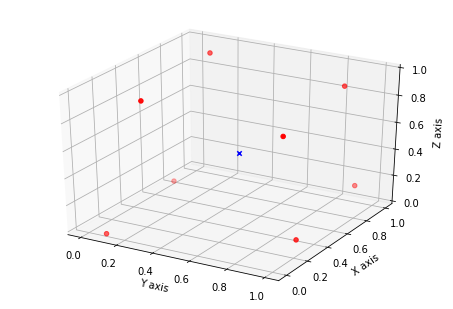

In [39]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
import statistics

fig = plt.figure()
ax = Axes3D(fig)

x = [ 0.7319, -0.4006, -0.7319,  0.8529,  0.9055, -0.2269, -0.5582,
          1.0265 ]
y =  [ 0.1290, -0.0706, -0.1290,  0.1504, -0.8558, -1.0554, -1.1139,
         -0.8344 ]
z =  [ 0.6691,  0.9135, -0.6691, -0.5000,  0.6691,  0.9135, -0.6691,
        -0.5000 ]

x=[(i-min(x))/(max(x)-min(x)) for i in x]

y=[(i-min(y))/(max(y)-min(y)) for i in y]

z=[(i-min(z))/(max(z)-min(z)) for i in z]

verts = [list(zip(x, y,z))]
#ax.add_collection3d(Poly3DCollection(verts))
ax.scatter(x, y, z, c='r', marker='o')
ax.set_xlabel('Y axis')
ax.set_ylabel('X axis')
ax.set_zlabel('Z axis')
ax.set_zlim(0, 1)

xbar = sum(x)/len(x)
ybar = sum(y)/len(y)
zbar = sum(z)/len(z)

ax.scatter(xbar, ybar, zbar, c='b', marker='x')

C = np.array((xbar ,ybar, zbar))
P = [np.array((x[i] ,y[i], z[i])) for i in range(len(x))]
#print(C,P)
D = [np.linalg.norm(a-C) for a in P]
#print(D)
M = statistics.median(D)
#print(M)
SD = statistics.stdev(D)
#print(SD)
circularity = M/SD
print("circularity: ",circularity)

plt.show()

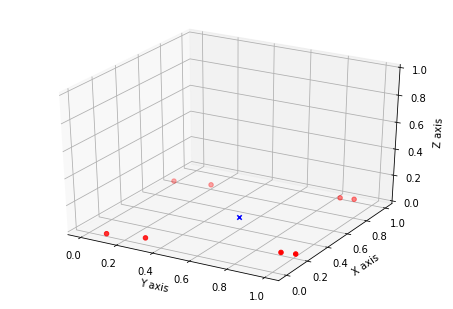

In [10]:
# for the report - delete later

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
fig = plt.figure()
ax = Axes3D(fig)

x = [ 0.7319, -0.4006, -0.7319,  0.8529,  0.9055, -0.2269, -0.5582,
          1.0265 ]
y =  [ 0.1290, -0.0706, -0.1290,  0.1504, -0.8558, -1.0554, -1.1139,
         -0.8344 ]
z =  [ 0.0,  0.0, 0.0, 0.0,  0.0,  0.0, 0.0001,
        0.0 ]
#z = [-1,-1,-1,-1,-1,-1,-1,-1]

x=[(i-min(x))/(max(x)-min(x)) for i in x]

y=[(i-min(y))/(max(y)-min(y)) for i in y]

z=[(i-min(z))/(1) for i in z]

verts = [list(zip(x, y, z))]
#ax.add_collection3d(Poly3DCollection(verts))
ax.scatter(x, y, z, c='r', marker='o')
ax.set_xlabel('Y axis')
ax.set_ylabel('X axis')
ax.set_zlabel('Z axis')
ax.set_zlim(0, 1)

xbar = sum(x)/len(x)
ybar = sum(y)/len(y)
zbar = sum(z)/len(z)

ax.scatter(xbar, ybar, zbar, c='b', marker='x')

plt.show()

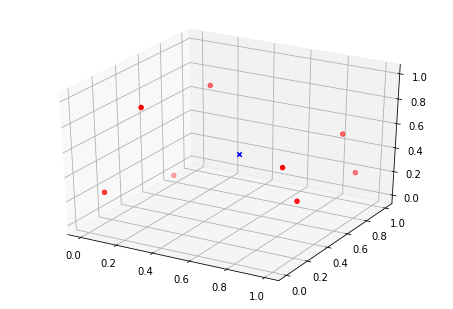

In [15]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
fig = plt.figure()
ax = Axes3D(fig)
x = [ 0.7319, -0.4006, -0.7319,  0.8529,  0.9055, -0.2269, -0.5582,
          1.0265 ]
y =  [ 0.1290, -0.0706, -0.1290,  0.1504, -0.8558, -1.0554, -1.1139,
         -0.8344 ]
z = [ 1.0587,  1.2730,  0.7061,  0.8346,  1.1649,  1.4251,  0.9184,
          0.9816]
x=[(i-min(x))/(max(x)-min(x)) for i in x]
y=[(i-min(y))/(max(y)-min(y)) for i in y]
z=[(i-min(z))/(max(z)-min(z)) for i in z]

verts = [list(zip(x, y,z))]
#ax.add_collection3d(Poly3DCollection(verts))
ax.scatter(x, y, z, c='r', marker='o')

xbar = sum(x)/len(x)
ybar = sum(y)/len(y)
zbar = sum(z)/len(z)

ax.scatter(xbar, ybar, zbar, c='b', marker='x')

xdiff = [xi-xbar for xi in x]
ydiff = [yi-ybar for yi in y]
zdiff = [zi-zbar for zi in z]

points = zip(x,y,x)

#xsd = np.std()

plt.show()

Trial #2

In [418]:
model.forward(torch.Tensor(obj).to(device), extract_z=True)

 vertexs_recovered: tensor([[ 0.7697, -0.3815, -0.7059,  0.8541,  0.9459, -0.1985, -0.5407,
          1.0282]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.4006, -0.7319,  0.8529,  0.9055, -0.2269, -0.5582,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       6.5134, device='cuda:0')
z output vec: tensor([[ 0.1056, -0.9291,  0.2476,  0.0000,  0.1110, -0.9236,  0.2529,
          0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000, -0.0438,
         -0.0000, -0.0000, -0.0000, -0.4322, -0.0069, -0.0080, -0.0050,
         -0.0045, -0.0000,  0.0000, -0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0')


tensor([[ 0.6459,  0.4539,  0.7028,  0.7240,  0.7935,  0.6045,  0.8322,
          0.8384]], device='cuda:0')

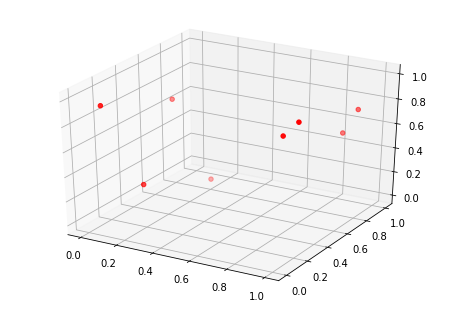

In [419]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
fig = plt.figure()
ax = Axes3D(fig)
x = [ 0.7319, -0.4006, -0.7319,  0.8529,  0.9055, -0.2269, -0.5582,
          1.0265 ]
y =  [ 0.1290, -0.0706, -0.1290,  0.1504, -0.8558, -1.0554, -1.1139,
         -0.8344 ]
z = [ 0.6459,  0.4539,  0.7028,  0.7240,  0.7935,  0.6045,  0.8322,
          0.8384]
x=[(i-min(x))/(max(x)-min(x)) for i in x]
y=[(i-min(y))/(max(y)-min(y)) for i in y]
z=[(i-min(z))/(max(z)-min(z)) for i in z]

verts = [list(zip(x, y,z))]
#ax.add_collection3d(Poly3DCollection(verts))
ax.scatter(x, y, z, c='r', marker='o')
plt.show()

Test Performance

In [60]:
import torch.utils.data
dataset = torch.utils.data.TensorDataset(test_xy[:,:,:], test_xyz[:,:,:])
loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

cuda:0


/home/mishra/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


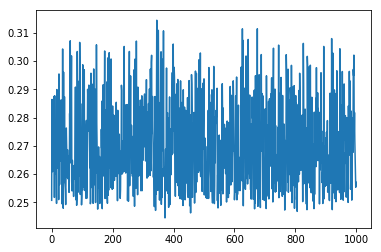

In [64]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)
model.to(device)
criterion = nn.L1Loss()
lr, epochs, batch_size = 1e-1 , 1 , 1
optimizer = torch.optim.SGD(model.parameters(), lr = lr )
accum=[]
i = 0
for k in range(epochs):
    localaccum = []
    for xy, xyz in iter(loader):
        i =  i+1
        local_xy = Variable(xy)
        #print(local_xy)
        local_xyz = Variable(xyz)
        local_xy = local_xy.to(device)
        local_xyz = local_xyz.to(device)
        outputs = model.forward(local_xy) #[val_msda,val_sym,z_star_msda,z_star_sym,G]
        output = outputs[0].to(device)
        #print("output:",output)
        #print("actual:", local_xyz[:,2,0:8])
        #loss = criterion(output, local_xyz[:,2,0:8])
        loss = criterion(output, torch.Tensor.new_zeros(output, output.size()))
        
        #print(local_xy, local_xyz)
        #if (i%100 == 0): print("network loss -> ", loss)
        #model.zero_grad()
        #loss.backward()
        #optimizer.step()
        localaccum.append(loss.data[0])
    accum.append(np.mean(localaccum))
plt.plot(localaccum);                                           

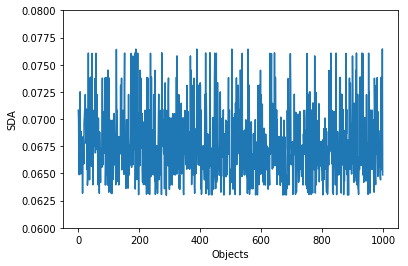

In [139]:
plt.ylabel('SDA')
plt.xlabel('Objects')
plt.ylim((0.06,0.08))
plt.plot(localaccum[0:1000])